In [1]:
import matplotlib
import json
import pandas as pd

matplotlib.rcParams["figure.figsize"] = (10, 10)

with open("export-2022-10-14T09:41:52Z.json") as f:
    testnet_export = json.load(f)

In [53]:
EXCLUDE_DEV_WALLETS = [
    "dys1sx3mjqcsvzp8apeduhaahyxvadczefyde47pfy",
    "dys1enyja0fe7d92lkuuzdss6ytp5e6pfkz3pqdckz",
    "dys1ffwuercwjhp7z07jln6f5edapqvzd3xvk24lka",
    "dys17fqd37ha4u4fku8s9p9ag0n7xhn4fz96jfmv7l",
    "dys19vka2zs9vksqtlecnvt5ydlyyvjnqj8ev892v9",
    "dys163p9eah2z7z74mwjdl39fmk440he6tt7jds40x",
    "dys1xhcztck0f86e74tchyz4vzwyxn97zpt6z9ym5y",
]


def get_airdrop_acounts(exported_snapshot):
    df = pd.json_normalize(exported_snapshot["app_state"]["auth"]["accounts"])
    df = df[~df["account_number"].isnull()]
    df = df[~df["sequence"].isnull()]
    df = df.astype({"account_number": int, "sequence": int})
    df["txs"] = df["sequence"]
    df = df[~(df["account_number"] == 0)]

    # Exclude accounts with no transactions
    df = df[df["txs"] > 0]

    # Remove developer test accounts
    df = df[~df.address.isin(EXCLUDE_DEV_WALLETS)]

    # Sort by account number
    df = df.set_index(df.address).sort_index()

    # get the scheduled runs by account
    runs = pd.json_normalize(
        exported_snapshot["app_state"]["dyson"]["scheduled_run_list"]
    )

    df = df.set_index("address").join(
        runs.groupby(["creator"]).agg(
            scheduled_run_count=pd.NamedAgg(column="creator", aggfunc="count")
        )
    )
    df["scheduled_run_count"] = df["scheduled_run_count"].fillna(0).astype(int)
    df = df.reset_index().set_index(df.account_number)

    # get the storage by account
    storage = pd.json_normalize(exported_snapshot["app_state"]["dyson"]["storage_list"])

    df = df.set_index("address").join(
        storage.groupby(["creator"]).agg(
            storage_list_count=pd.NamedAgg(column="creator", aggfunc="count")
        )
    )
    df = df.reset_index().set_index(df.account_number)

    # get the names by account
    names = pd.json_normalize(exported_snapshot["app_state"]["names"]["nameList"])

    df = df.set_index("address").join(
        names.groupby(["owner"]).agg(
            name_count=pd.NamedAgg(column="owner", aggfunc="count")
        )
    )
    df["name_count"] = df["name_count"].fillna(0).astype(int)
    df = df.reset_index().sort_values("account_number").reset_index()

    return df[
        [
            "address",
            "txs",
            "account_number",
            "scheduled_run_count",
            "name_count",
        ]
    ]


accounts = get_airdrop_acounts(testnet_export)

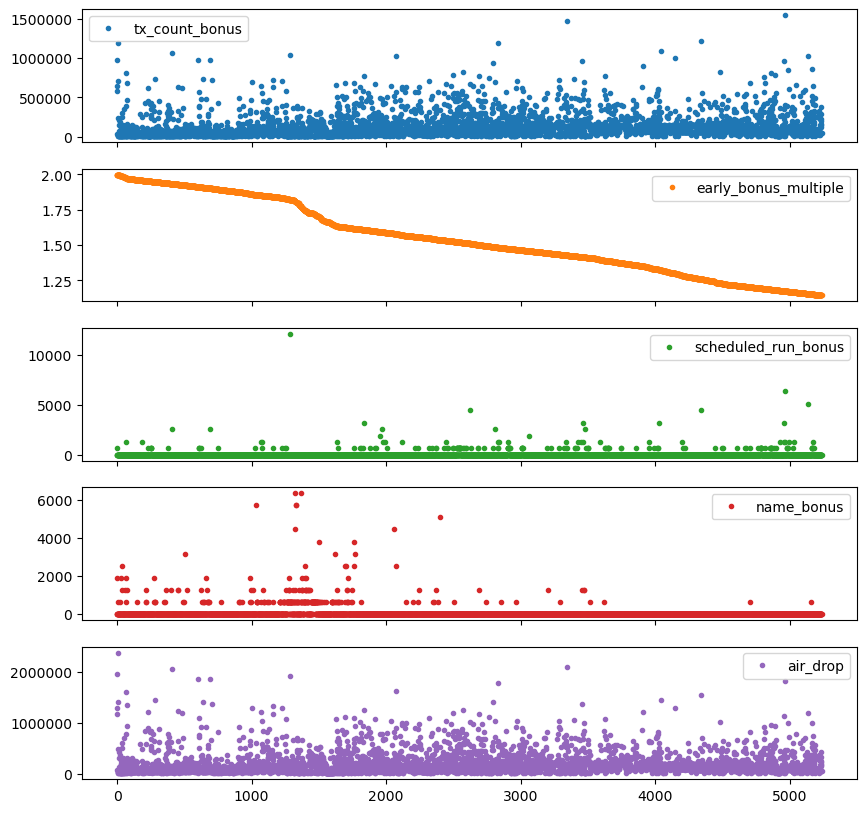

In [131]:
MEDIAN_GAS_USED = 63640
GAS_PRICE = 0.001
TX_DYS = MEDIAN_GAS_USED * GAS_PRICE  # ~63dys

accounts["early_bonus_multiple"] = 2 + ((-1 / 10000) * accounts["account_number"])
accounts["tx_count_bonus"] = accounts["txs"] * (TX_DYS * 100)
accounts["scheduled_run_bonus"] = accounts["scheduled_run_count"] * int(10 * TX_DYS)
accounts["name_bonus"] = accounts["name_count"] * int(10 * TX_DYS)

accounts["air_drop"] = (
    (accounts["tx_count_bonus"] * accounts["early_bonus_multiple"])
    + accounts["scheduled_run_bonus"]
    + accounts["name_bonus"]
).astype(int)

ax = accounts[
    [
        "tx_count_bonus",
        "early_bonus_multiple",
        "scheduled_run_bonus",
        "name_bonus",
        "air_drop",
    ]
].plot(subplots=True, style=".")
ax[0].ticklabel_format(useOffset=False, style="plain")
ax[4].ticklabel_format(useOffset=False, style="plain")

In [144]:
community_air_drop = accounts.set_index("address").sort_index()[
    [
        "tx_count_bonus",
        "early_bonus_multiple",
        "scheduled_run_bonus",
        "name_bonus",
        "air_drop",
    ]
]
community_air_drop.to_csv("community_air_drop.csv")

community_air_drop

tx_count_bonus  \
address                                                      
dys100acrt5g76ed6sc5v5splmjkpt4cd8m726shdq          6364.0   
dys100lnxvq26dcvkkjc5hy8e54lgpzpqma2z7lqrm         38184.0   
dys100qzcjdn7skz478ua0fh6vsahpyupjw95gcfua         50912.0   
dys100y4wyt3en9mg89rz7c78emulljcfq54fm3cz8         31820.0   
dys100ywd70g05apdtxncljl7l2jaf6e5gdrmlmgez        152736.0   
...                                                    ...   
dys1zzh5amdvmuxvg6xhzesnt7zuexkagfnjqc9evf         82732.0   
dys1zzrgap0ka74c9357nrqrxxx996yc56ay5cu5s0         89096.0   
dys1zzu2tu792mznqsj9syjtc2a9yw4kvcyqnsttgn        241832.0   
dys1zzvxxeke3k4gs2m9vmplwhyn4rcljs7w7a327p         31820.0   
dys1zzy37dxua9myexcw8x992sshr7lytgvgr92ag8         63640.0   

                                            early_bonus_multiple  \
address                                                            
dys100acrt5g76ed6sc5v5splmjkpt4cd8m726shdq                1.4120   
dys100lnxvq26dcvkkjc5hy8e54lgpzpqma2z7lqrm                1.5348   
dys100qzcjdn7skz478ua0fh6vsahpyupjw95gcfua                1.5091   
dys100y4wyt3en9mg89rz7c78emulljcfq54fm3cz8                1.9602   
dys100ywd70g05apdtxncljl7l2jaf6e5gdrmlmgez                1.4579   
...                                                          ...   
dys1zzh5amdvmuxvg6xhzesnt7zuexkagfnjqc9evf                1.6141   
dys1zzrgap0ka74c9357nrqrxxx996yc56ay5cu5s0                1.2286   
dys1zzu2tu792mznqsj9syjtc2a9yw4kvcyqnsttgn                1.3094   
dys1zzvxxeke3k4gs2m9vmplwhyn4rcljs7w7a327p                1.8851   
dys1zzy37dxua9myexcw8x992sshr7lytgvgr92ag8                1.6106   

                                            scheduled_run_bonus  name_bonus  \
address                                                                       
dys100acrt5g76ed6sc5v5splmjkpt4cd8m726shdq                    0           0   
dys100lnxvq26dcvkkjc5hy8e54lgpzpqma2z7lqrm                    0           0   
dys100qzcjdn7skz478ua0fh6vsahpyupjw95gcfua                    0           0   
dys100y4wyt3en9mg89rz7c78emulljcfq54fm3cz8                    0           0   
dys100ywd70g05apdtxncljl7l2jaf6e5gdrmlmgez                    0           0   
...                                                         ...         ...   
dys1zzh5amdvmuxvg6xhzesnt7zuexkagfnjqc9evf                    0           0   
dys1zzrgap0ka74c9357nrqrxxx996yc56ay5cu5s0                    0           0   
dys1zzu2tu792mznqsj9syjtc2a9yw4kvcyqnsttgn                    0           0   
dys1zzvxxeke3k4gs2m9vmplwhyn4rcljs7w7a327p                    0           0   
dys1zzy37dxua9myexcw8x992sshr7lytgvgr92ag8                    0           0   

                                            air_drop  
address                                               
dys100acrt5g76ed6sc5v5splmjkpt4cd8m726shdq      8985  
dys100lnxvq26dcvkkjc5hy8e54lgpzpqma2z7lqrm     58604  
dys100qzcjdn7skz478ua0fh6vsahpyupjw95gcfua     76831  
dys100y4wyt3en9mg89rz7c78emulljcfq54fm3cz8     62373  
dys100ywd70g05apdtxncljl7l2jaf6e5gdrmlmgez    222673  
...                                              ...  
dys1zzh5amdvmuxvg6xhzesnt7zuexkagfnjqc9evf    133537  
dys1zzrgap0ka74c9357nrqrxxx996yc56ay5cu5s0    109463  
dys1zzu2tu792mznqsj9syjtc2a9yw4kvcyqnsttgn    316654  
dys1zzvxxeke3k4gs2m9vmplwhyn4rcljs7w7a327p     59983  
dys1zzy37dxua9myexcw8x992sshr7lytgvgr92ag8    102498  

[5236 rows x 5 columns]

In [145]:
air_drop_stats = accounts.air_drop.describe()[["min", "25%", "50%", "75%", "max"]]
air_drop_stats["sum"] = accounts.air_drop.sum()
print(air_drop_stats.apply(lambda x: f"{x:,.0f} dys").to_markdown())

|     | air_drop        |
|:----|:----------------|
| min | 7,310 dys       |
| 25% | 67,359 dys      |
| 50% | 119,145 dys     |
| 75% | 202,944 dys     |
| max | 2,377,755 dys   |
| sum | 951,524,691 dys |
